# Pairs / Spread Analysis

This notebook demonstrates a simple research workflow:
- Load and align close prices
- Compute rolling correlations (diagnostic)
- Estimate a time-varying hedge ratio (Kalman filter)
- Build the spread (residual) and compute an adaptive z-score
- Run basic diagnostics (half-life, optional ADF/KPSS)


In [3]:
# Notebook setup: ensure the repository root (with `src/`) is importable
from pathlib import Path
import sys

here = Path().resolve()
root = here if (here / "src").exists() else here.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import pandas as pd
import matplotlib.pyplot as plt

import src.core as core

# Pair configuration
ASSET_Y = "BTC-USD"
ASSET_X = "QQQ"

# Analysis parameters
CSV_PATH = root /"data"/"raw"/"prices.csv"  # update if needed
ALIGN = "inner"                  # recommended for 24/7 vs session-based markets
DELTA = 1e-5                      # Kalman: higher => faster adaptation
R = 1.5e-3                          # Kalman: higher => smoother estimates
ZSPAN = 45                  # EWM z-score span
ENTRY_Z = 2.0
EXIT_Z = 0.5


,BTC-USD,QQQ
Date,,
2025-11-21,85090.687500,590.070007
2025-11-24,88270.562500,605.159973
2025-11-25,87341.890625,608.890015
2025-11-26,90518.367188,614.270020
2025-11-28,90919.265625,619.250000


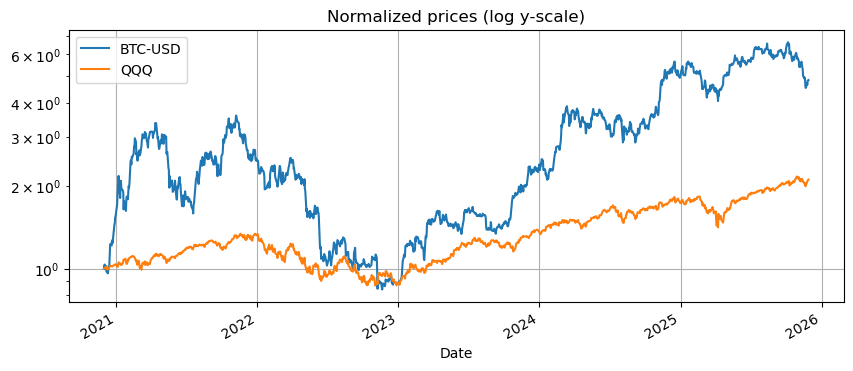

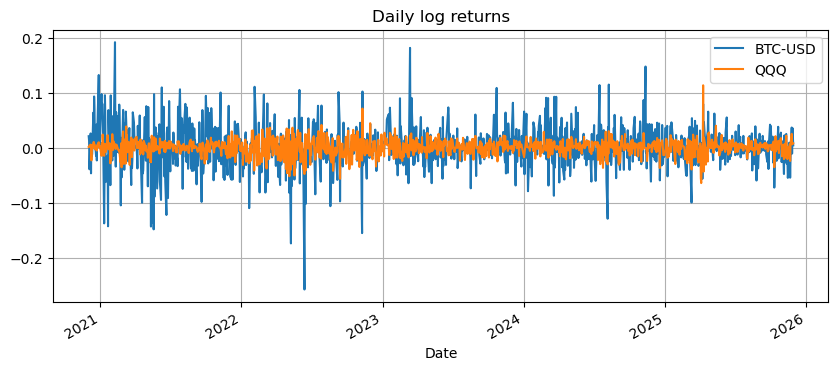

In [4]:
# 1) Load close prices (calendar alignment matters)
closes = core.load_and_prepare_closes(CSV_PATH, align=ALIGN)
display(closes.tail())

# Quick visual checks
base = closes / closes.iloc[0]
ax = base.plot(logy=True, figsize=(10, 4), title="Normalized prices (log y-scale)")
ax.grid(True)

returns = core.compute_log_returns(closes)
ax = returns.plot(figsize=(10, 4), title="Daily log returns")
ax.grid(True)


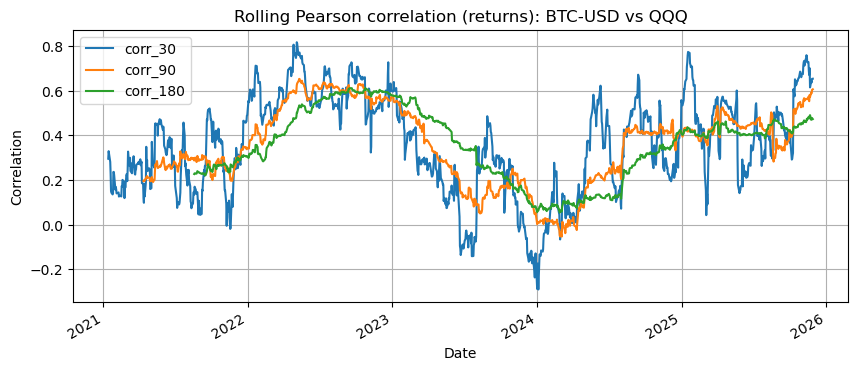

In [5]:
# 2) Rolling correlations (diagnostic only; not a cointegration test)
corr = core.rolling_correlation_dual(returns, ASSET_X, ASSET_Y, 30, 90, 180)
ax = corr.plot(figsize=(10, 4))
ax.set_title(f"Rolling Pearson correlation (returns): {ASSET_Y} vs {ASSET_X}")
ax.set_xlabel("Date")
ax.set_ylabel("Correlation")
ax.grid(True)


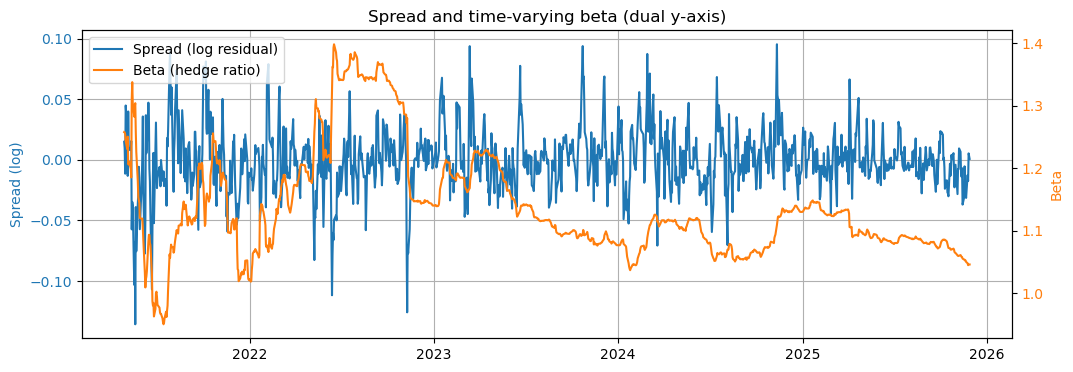

Latest alpha: 4.694912807708972
Latest beta: 1.0456589380035437
{'adf_stat': -16.918104776999083, 'pvalue': 9.988191392934826e-30}
{'kpss_stat': 0.0868041218170657, 'pvalue': 0.1}

 1 0.6278537639586598

 2 0.40321577545682363

 5 0.06719692534332476

 10 0.01271358519198252

 20 0.03302030544993544


C:\Users\siste\Desktop\CURSOS\Aprendizaje Trader Algo\Proyectos_trading_algoritmico\Cross_assets_pair_analyzer\src\core.py:339: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, *_ = kpss(s, regression=regression, nlags=nlags)


In [8]:
# 3) Time-varying hedge ratio and spread (residual) in log-price space

log_prices = core.compute_log_prices(closes)
k = core.kalman_hedge_ratio(log_prices, ASSET_Y, ASSET_X, delta=DELTA, r=R, include_intercept=True)

burn = 100

#ax = k["beta"].iloc[burn:].plot(figsize=(10, 3), title="Time-varying hedge ratio (beta)", legend = True)
#ax.grid(True)


#ax = k["spread"].iloc[burn:].plot(figsize=(10,3), title="Spread (after burn-in)", legend = True)
#ax.grid(True)"

beta = k["beta"].dropna()
spread = k["spread"].dropna()


# Alinear índices por si hay NaNs distintos
df_plot = k[["beta", "spread"]].dropna().iloc[burn:]

fig, ax1 = plt.subplots(figsize=(12, 4))

# Spread (eje izquierdo)
color_spread = "tab:blue"
ax1.plot(df_plot.index, df_plot["spread"], color=color_spread, linewidth=1.5, label="Spread (log residual)")
ax1.set_ylabel("Spread (log)", color=color_spread)
ax1.tick_params(axis="y", labelcolor=color_spread)
ax1.grid(True)

# Beta (eje derecho)
ax2 = ax1.twinx()
color_beta = "tab:orange"
ax2.plot(df_plot.index, df_plot["beta"], color=color_beta, linewidth=1.5, label="Beta (hedge ratio)")
ax2.set_ylabel("Beta", color=color_beta)
ax2.tick_params(axis="y", labelcolor=color_beta)

ax1.set_title("Spread and time-varying beta (dual y-axis)")

# Leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

print("Latest alpha:", float(k["alpha"].dropna().iloc[-1]))
print("Latest beta:", float(k["beta"].dropna().iloc[-1]))

print(core.adf_test(spread))
print(core.kpss_test(spread))
for lag in [1,2,5,10,20]:
    print("\n", lag, spread.autocorr(lag))




Half-life estimate (bars): 1.49
ADF: {'adf_stat': -16.918104776999083, 'pvalue': 9.988191392934826e-30}
KPSS: {'kpss_stat': 0.0868041218170657, 'pvalue': 0.1}


C:\Users\siste\Desktop\CURSOS\Aprendizaje Trader Algo\Proyectos_trading_algoritmico\Cross_assets_pair_analyzer\src\core.py:339: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, *_ = kpss(s, regression=regression, nlags=nlags)


,side,start,end,duration_bars,z_start,z_peak,z_end
0,SHORT,2021-02-08,2021-02-10,2,2.127161,2.127161,0.252123
1,LONG,2021-04-19,2021-04-26,5,-2.011773,-2.011773,0.068973
2,LONG,2021-05-17,2021-05-24,5,-2.516837,-2.587851,-0.374034
3,LONG,2021-06-21,2021-06-23,2,-2.037359,-2.037359,0.144255
4,SHORT,2021-07-26,2021-08-02,5,2.397098,2.397098,-0.296270


Number of events: 32


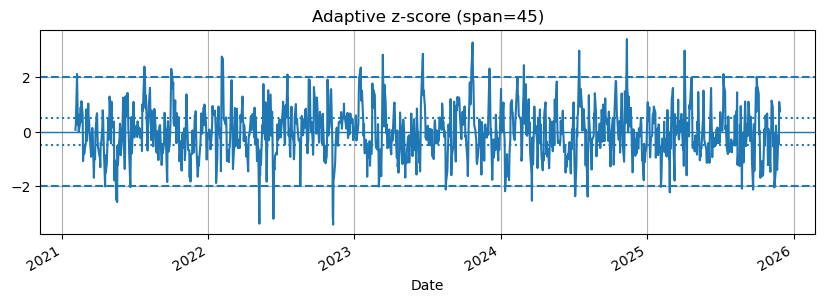

In [ ]:
# 4) Adaptive z-score (EWM mean/std)
z = core.zscore_ewm(k["spread"], span=ZSPAN)

ax = z.plot(figsize=(10, 3), title=f"Adaptive z-score (span={ZSPAN})")
ax.axhline(ENTRY_Z, linestyle="--")
ax.axhline(-ENTRY_Z, linestyle="--")
ax.axhline(EXIT_Z, linestyle=":")
ax.axhline(-EXIT_Z, linestyle=":")
ax.axhline(0, linewidth=1)
ax.grid(True)

hl = core.half_life(k["spread"])
print(f"Half-life estimate (bars): {hl:.2f}")

# Optional: stationarity tests (requires statsmodels)
try:
    print("ADF:", core.adf_test(k["spread"]))
    print("KPSS:", core.kpss_test(k["spread"]))
except Exception as e:
    print("ADF/KPSS not available (install statsmodels):", e)

events = core.zscore_events(z, entry=2.0, exit=0.5)
display(events.head())
print("Number of events:", len(events))

summary = event_summary(events, z, entry=2.0)
for k_, v in summary.items():
    print(f"{k_:>26}: {v}")
